<a href="https://colab.research.google.com/github/castorhyun/DeepLearningZeroToAll/blob/master/Image_segmentation_unet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Image Segmentation

### 다음과 같은 일반적인 workflow로 진행
1. Visualize data/perform some exploratory data analysis
2. Set up data pipeline and preprocessing
3. Build model
4. Train model
5. Evaluate model
6. Repeat

## Project 설명

### Task
* GIANA dataset으로 위내시경 이미지에서 용종을 segmentation 해보자.
* 데이터 불러오기를 제외한 딥러닝 트레이닝 과정을 직접 구현해보는 것이 목표 입니다.


* This code is borrowed from [TensorFlow tutorials/Image Segmentation](https://github.com/tensorflow/models/blob/master/samples/outreach/blogs/segmentation_blogpost/image_segmentation.ipynb) which is made of `tf.keras.layers`.
* You can see the detail description [tutorial link](https://github.com/tensorflow/models/blob/master/samples/outreach/blogs/segmentation_blogpost/image_segmentation.ipynb)  

### Dataset
* [Gastrointestinal Image ANAlys Challenges (GIANA)](https://giana.grand-challenge.org) Dataset (345MB)
  * Train data: 300 images with RGB channels (bmp format)
  * Train lables: 300 images with 1 channels (bmp format)
  * Image size: 574 x 500
* Training시 **image size는 256**으로 resize

### Baseline code
* Dataset: train, test로 split
* Input data shape: (`batch_size`, 256, 256, 3)
* Output data shape: (`batch_size`, 256, 256, 1)
* Architecture: 
  * 간단한 Encoder-Decoder 구조
  * U-Net 구조
  * [`tf.keras.layers`](https://www.tensorflow.org/api_docs/python/tf/keras/layers) 사용
* Training
  * `tf.data.Dataset` 사용
  * `model.fit()` 사용 for weight update
* Evaluation
  * MeanIOU: Image Segmentation에서 많이 쓰이는 evaluation measure
  * tf.version 2.0 API: [`tf.keras.metrics.MeanIoU`](https://www.tensorflow.org/versions/r2.0/api_docs/python/tf/keras/metrics/MeanIoU)

### Try some techniques
* Change model architectures (Custom model)
  * Try another models (Unet 모델)
* Various regularization methods

## Import modules

### Import colab modules for Google Colab (if necessary)

In [1]:
# 아래코드는 2.1 버전에서 동작하므로 실행 필요!! ( 2.3 버전과 충돌있음 )
!pip install tensorflow-gpu==2.1

In [2]:
use_colab = True
assert use_colab in [True, False]

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### Import base modules

In [4]:
from __future__ import absolute_import, division
from __future__ import print_function, unicode_literals

import os
import time
import shutil
import functools

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib as mpl
mpl.rcParams['axes.grid'] = False
mpl.rcParams['figure.figsize'] = (12,12)

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import matplotlib.image as mpimg
import pandas as pd
from PIL import Image
from IPython.display import clear_output

import tensorflow as tf
import tensorflow_addons as tfa
print(tf.__version__)

from tensorflow.keras import layers
from tensorflow.keras import losses
from tensorflow.keras import models

2.1.0


# 사용 모델 선택
* 학습 및 inference에서 사용할 모델 선택

In [5]:
is_train = True

model_name = 'u-net'  # ed_model로 시작
assert model_name in ['ed_model', 'u-net'] # 이 두가지 선택지에 포함되는지 확인

## 데이터 수집 및 Visualize

### Download data

이 프로젝트는 [Giana Dataset](https://giana.grand-challenge.org/Dates/)을 이용하여 진행한다.

In [6]:
if use_colab:
    DATASET_PATH='/content/drive/My Drive/0003. AICC 자료/001. Study 자료/modu_Class/modu_part3/Day4_image_segmentation/datasets/'
else:
    DATASET_PATH='../../datasets/'

if not os.path.isdir(DATASET_PATH):
    os.makedirs(DATASET_PATH)

    import urllib.request
    u = urllib.request.urlopen(url='http://bigfile.mail.naver.com/bigfileupload/download?fid=8enZaAIq1NKXFqMjK3YXaxKZFCYZKAUmKxgZKxUmKqUqFCYwFog9aA2dKqvlHqKqK6KmK4kvFAFopxIvF6t9Kqg9KoEZM6pvFAkoFrt/')
    data = u.read()
    u.close()

    with open('sd_train.zip', "wb") as f :
        f.write(data)
        print('Data has been downloaded')

    shutil.move(os.path.join('sd_train.zip'), os.path.join(DATASET_PATH))
    file_path = os.path.join(DATASET_PATH, 'sd_train.zip')

    import zipfile
    zip_ref = zipfile.ZipFile(file_path, 'r')
    zip_ref.extractall(DATASET_PATH)
    zip_ref.close()
    print('Data has been extracted.')
    
else:
    print('Data has already been downloaded and extracted.')


Data has already been downloaded and extracted.


### Split dataset into train data and test data

In [7]:
DATASET_PATH='/content/drive/My Drive/0003. AICC 자료/001. Study 자료/modu_Class/modu_part3/Day4_image_segmentation/datasets'


dataset_dir = os.path.join(DATASET_PATH, 'sd_train') # 데이터셋의 가장 상위의 폴더

img_dir = os.path.join(dataset_dir, "train") # 그 안에 train data와 label data가 폴더로 구분
label_dir = os.path.join(dataset_dir, "train_labels")

In [8]:
print(dataset_dir)
print(img_dir)
print(label_dir)

/content/drive/My Drive/0003. AICC 자료/001. Study 자료/modu_Class/modu_part3/Day4_image_segmentation/datasets/sd_train
/content/drive/My Drive/0003. AICC 자료/001. Study 자료/modu_Class/modu_part3/Day4_image_segmentation/datasets/sd_train/train
/content/drive/My Drive/0003. AICC 자료/001. Study 자료/modu_Class/modu_part3/Day4_image_segmentation/datasets/sd_train/train_labels


In [9]:
# 데이터셋 파일경로를 통해 데이터를 로드한다. (대용량 데이터에 효과적)

x_train_filenames = [os.path.join(img_dir, filename) for filename in os.listdir(img_dir)]
x_train_filenames.sort()
y_train_filenames = [os.path.join(label_dir, filename) for filename in os.listdir(label_dir)]
y_train_filenames.sort()
# 학습 데이터셋의 주소(path)를 가져와서 사용한다.

In [10]:
print(len(x_train_filenames))
print(len(y_train_filenames))
print(x_train_filenames)
print(y_train_filenames)

600
600
['/content/drive/My Drive/0003. AICC 자료/001. Study 자료/modu_Class/modu_part3/Day4_image_segmentation/datasets/sd_train/train/1 - Copy.bmp', '/content/drive/My Drive/0003. AICC 자료/001. Study 자료/modu_Class/modu_part3/Day4_image_segmentation/datasets/sd_train/train/1.bmp', '/content/drive/My Drive/0003. AICC 자료/001. Study 자료/modu_Class/modu_part3/Day4_image_segmentation/datasets/sd_train/train/10 - Copy.bmp', '/content/drive/My Drive/0003. AICC 자료/001. Study 자료/modu_Class/modu_part3/Day4_image_segmentation/datasets/sd_train/train/10.bmp', '/content/drive/My Drive/0003. AICC 자료/001. Study 자료/modu_Class/modu_part3/Day4_image_segmentation/datasets/sd_train/train/100 - Copy.bmp', '/content/drive/My Drive/0003. AICC 자료/001. Study 자료/modu_Class/modu_part3/Day4_image_segmentation/datasets/sd_train/train/100.bmp', '/content/drive/My Drive/0003. AICC 자료/001. Study 자료/modu_Class/modu_part3/Day4_image_segmentation/datasets/sd_train/train/101 - Copy.bmp', '/content/

In [11]:
# test set 20% 분리
x_train_filenames, x_test_filenames, y_train_filenames, y_test_filenames = \
                    train_test_split(x_train_filenames, y_train_filenames, test_size=0.2)

In [12]:
num_train_examples = len(x_train_filenames)
num_test_examples = len(x_test_filenames)
# 데이터셋의 길이를 확인하는 파트
print("Number of training examples: {}".format(num_train_examples))
print("Number of test examples: {}".format(num_test_examples))

Number of training examples: 480
Number of test examples: 120


In [13]:
len(y_train_filenames)

480

### Visualize

데이터 셋에서 5장 (`display_num`)의 이미지를 살펴보자.

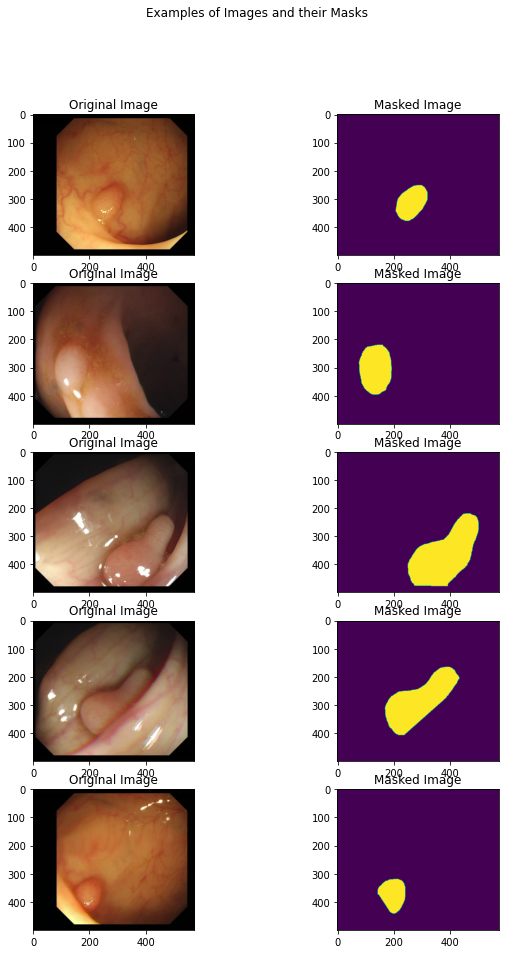

In [14]:
display_num = 5

r_choices = np.random.choice(num_train_examples, display_num)

plt.figure(figsize=(10, 15))
for i in range(0, display_num * 2, 2):
    img_num = r_choices[i // 2]
    x_pathname = x_train_filenames[img_num]
    y_pathname = y_train_filenames[img_num]

    plt.subplot(display_num, 2, i + 1)
    plt.imshow(Image.open(x_pathname))
    plt.title("Original Image")

    example_labels = Image.open(y_pathname)
    label_vals = np.unique(example_labels)

    plt.subplot(display_num, 2, i + 2)
    plt.imshow(example_labels)
    plt.title("Masked Image")
    
plt.suptitle("Examples of Images and their Masks")
plt.show()

## Data pipeline and preprocessing 만들기

### Set up hyper-parameters

Hyper-parameter를 셋팅해보자. 이미지 사이즈, 배치 사이즈 등 training parameter들을 셋팅해보자.

In [15]:
# Set hyperparameters
image_size = 256
img_shape = (image_size, image_size, 3) # RGB
batch_size = 32 # model.fit의 버그때문에 batch size를 데이터셋의 수보다 작게 설정해주셔야합니다.
max_epochs = 100

if use_colab:
    checkpoint_dir ='/content/drive/My Drive/0003. AICC 자료/001. Study 자료/modu_Class/modu_part3/Day4_image_segmentation/train_ckpt/segmentation/exp1'
    if not os.path.isdir(checkpoint_dir):
        os.makedirs(checkpoint_dir)
else:
    checkpoint_dir = './train_ckpt/segmentation/exp1'

### Build our input pipeline with `tf.data`

Input data pipeline을 만들기 가장 좋은 방법은 [**tf.data**](https://www.tensorflow.org/guide/datasets) (링크 참조) 를 사용하는 것이다. `tf.data` API 를 잘 읽어보자.


#### Our input pipeline will consist of the following steps:

TensorFlow segmentation tutorial input pipeline 참고 하였음.


> 1. 이미지와 레이블 모두 파일 이름에서 파일의 바이트를 읽습니다. 라벨은 실제로 각 픽셀이 용종데이터로 (1, 0)으로 주석이 달린 이미지입니다. 
> 2. 바이트를 이미지 형식으로 디코딩
> 3. 이미지 변환 적용 : (optional, input parameters에 따라서)
> * `resize`-이미지를 표준 크기로 조정합니다 (eda 또는 계산 / 메모리 제한에 의해 결정됨)
> * resize의 이유는 U-Net이 fully convolution networks 이므로 입력 크기에 의존하지 않기 때문입니다. 그러나 이미지 크기를 조정하지 않으면 가변 이미지 크기를 함께 배치 할 수 없으므로 배치 크기 1을 사용해야합니다.
> *  성능에 영향을 줄 수 있으므로 이미지 크기를 조정하여 미니 배치별로 이미지 크기를 조정하여 미니 배치별로 이미지 크기를 조정할 수도 있습니다.
> *`hue_delta`-RGB 이미지의 색조를 랜덤 팩터로 조정합니다. 이것은 실제 이미지에만 적용됩니다 (라벨 이미지가 아님). `hue_delta`는`[0, 0.5]`간격에 있어야합니다.
> *`horizontal_flip`-0.5 확률로 중심 축을 따라 이미지를 수평으로 뒤집습니다. 이 변환은 레이블과 실제 이미지 모두에 적용해야합니다.
> *`width_shift_range` 및`height_shift_range`는 이미지를 가로 또는 세로로 임의로 변환하는 범위 (전체 너비 또는 높이의 일부)입니다. 이 변환은 레이블과 실제 이미지 모두에 적용해야합니다.
> *`rescale`-이미지를 일정한 비율로 다시 조정합니다 (예 : 1/255.)
> 4. 데이터를 섞고, 데이터를 반복하여 학습합니다.

#### Why do we do these image transformations?

Data augmentation은 딥러닝을 이용한 이미지 처리분야 (classification, detection, segmentation 등) 에서 널리 쓰이는 테크닉이다. 자세한 내용은 아래 TensorFlow 공식 예제 링크로 대체한다.

> This is known as **data augmentation**. Data augmentation "increases" the amount of training data by augmenting them via a number of random transformations. During training time, our model would never see twice the exact same picture. This helps prevent [overfitting](https://developers.google.com/machine-learning/glossary/#overfitting) and helps the model generalize better to unseen data.

#### Processing each pathname

In [16]:
def _process_pathnames(fname, label_path):
    # We map this function onto each pathname pair
    img_str = tf.io.read_file(fname)
    img = tf.image.decode_bmp(img_str, channels=3) # RGB

    label_img_str = tf.io.read_file(label_path)
    label_img = tf.image.decode_bmp(label_img_str, channels=1) # BMP 0,1

    resize = [image_size, image_size]
    img = tf.image.resize(img, resize)
    label_img = tf.image.resize(label_img, resize)

    scale = 1 / 255. # 0~255 normalize => 0~1
    img = tf.cast(img, dtype=tf.float32) * scale
    label_img = tf.cast(label_img, dtype=tf.float32) * scale

    return img, label_img

#### Shifting the image

In [17]:
def shift_img(output_img, label_img, width_shift_range, height_shift_range):
    """This fn will perform the horizontal or vertical shift"""
    if width_shift_range or height_shift_range:
        if width_shift_range:
                width_shift_range = tf.random.uniform([],
                                                  -width_shift_range * img_shape[1],
                                                  width_shift_range * img_shape[1])
        if height_shift_range:
                height_shift_range = tf.random.uniform([],
                                                   -height_shift_range * img_shape[0],
                                                   height_shift_range * img_shape[0])
        output_img = tfa.image.translate(output_img,
                                         [width_shift_range, height_shift_range])
        label_img = tfa.image.translate(label_img,
                                        [width_shift_range, height_shift_range])
    return output_img, label_img

#### Flipping the image randomly

In [18]:
def flip_img(horizontal_flip, tr_img, label_img):
    if horizontal_flip:
        flip_prob = tf.random.uniform([], 0.0, 1.0)
        tr_img, label_img = tf.cond(tf.less(flip_prob, 0.5),
                                lambda: (tf.image.flip_left_right(tr_img), tf.image.flip_left_right(label_img)),
                                lambda: (tr_img, label_img))
    return tr_img, label_img

#### Assembling our transformations into our augment function

In [19]:
def _augment(img,
             label_img,
             resize=None,  # Resize the image to some size e.g. [256, 256]
             scale=1,  # Scale image e.g. 1 / 255.
             hue_delta=0.05,  # Adjust the hue of an RGB image by random factor
             horizontal_flip=True,  # Random left right flip,
             width_shift_range=0.05,  # Randomly translate the image horizontally
             height_shift_range=0.05):  # Randomly translate the image vertically 
    if resize is not None:
        # Resize both images
        label_img = tf.image.resize(label_img, resize)
        img = tf.image.resize(img, resize)
  
    if hue_delta:
        img = tf.image.random_hue(img, hue_delta)
  
    img, label_img = flip_img(horizontal_flip, img, label_img)
    img, label_img = shift_img(img, label_img, width_shift_range, height_shift_range)
    label_img = tf.cast(label_img, dtype=tf.float32) * scale
    img = tf.cast(img, dtype=tf.float32) * scale
    return img, label_img

In [20]:
def get_baseline_dataset(filenames,
                         labels,
                         preproc_fn=functools.partial(_augment),
                         threads=5,
                         batch_size=batch_size,
                         is_train=True):
    num_x = len(filenames)
    # Create a dataset from the filenames and labels
    dataset = tf.data.Dataset.from_tensor_slices((filenames, labels)) # train data가 들어간다.
    # num_parallel_calls 동시처리
    dataset = dataset.map(_process_pathnames, num_parallel_calls=threads)

    if is_train:# 학습을 진행할시에만 위에 augment를 진행합니다.
        dataset = dataset.map(preproc_fn, num_parallel_calls=threads)
        dataset = dataset.shuffle(num_x * 10)

    dataset = dataset.batch(batch_size)
    return dataset

### Set up train and test datasets
Note that we apply image augmentation to our training dataset but not our validation dataset.

In [21]:

train_dataset = get_baseline_dataset(x_train_filenames, y_train_filenames)
                                     
train_dataset = train_dataset.repeat() # model fit 사용을하기 때문에 사용

test_dataset = get_baseline_dataset(x_test_filenames,
                                    y_test_filenames,
                                    is_train=False)

In [22]:
train_dataset

<RepeatDataset shapes: ((None, 256, 256, 3), (None, 256, 256, 1)), types: (tf.float32, tf.float32)>

### Plot some train data

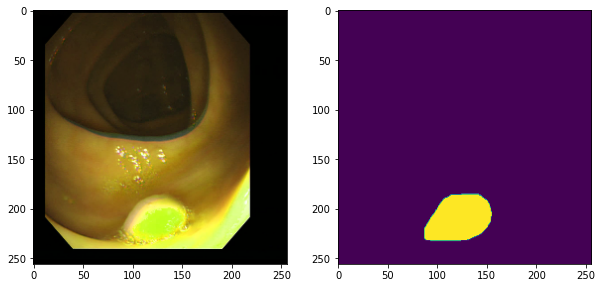

In [23]:
for images, labels in train_dataset.take(1):
    # Running next element in our graph will produce a batch of images
    plt.figure(figsize=(10, 10))
    img = images[0]

    plt.subplot(1, 2, 1)
    plt.imshow(img)

    plt.subplot(1, 2, 2)
    plt.imshow(labels[0, :, :, 0])
    plt.show() # train_dataset에 구성된 이미지들을 확인할 수 있습니다.

## Build the model

해당 프로젝트는 두 개의 네트워크를 만들어보는 것이 목표이다.
* Encoder-Decoder 스타일의 네트워크
* [U-Net](https://arxiv.org/abs/1505.04597)

### Encoder-Decoder architecture

#### Encoder
* 다음과 같은 구조로 Encoder로 만들어보자.
* `input data`의 shape이 다음과 같이 되도록 네트워크를 구성해보자
  * inputs = [batch_size, 256, 256, 3]
  * conv1 => [batch_size, 128, 128, 32]
  * conv2 => [batch_size, 64, 64, 64]
  * conv3 => [batch_size, 32, 32, 128]
  * outputs => [batch_size, 16, 16, 256]
* Convolution - Normalization - Activation 등의 조합을 다양하게 생각해보자.
* Pooling을 쓸지 Convolution with stride=2 로 할지 잘 생각해보자.
* `tf.keras.Sequential()`을 이용하여 만들어보자.
  
#### Decoder
* Encoder의 mirror 형태로 만들어보자.
* `input data`의 shape이 다음과 같이 되도록 네트워크를 구성해보자
  * inputs = encoder의 outputs = [batch_size, 16, 16, 256]
  * conv_transpose1 => [batch_size, 32, 32, 128]
  * conv_transpose2 => [batch_size, 64, 64, 64]
  * conv_transpose3 => [batch_size, 128, 128, 32]
  * outputs = [batch_size, 256, 256, 1]
* `tf.keras.Sequential()`을 이용하여 만들어보자.

In [24]:
model=tf.keras.Sequential(name='test')
model.add(layers.Conv2D(1, 2, input_shape=[4,4,1], padding='same'))
model.add(layers.Conv2DTranspose(1, 2, padding='same'))

In [25]:
pred = model(tf.random.normal([1,4,4,1]))
print(pred.shape)
model.summary()

(1, 4, 4, 1)
Model: "test"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 4, 4, 1)           5         
_________________________________________________________________
conv2d_transpose (Conv2DTran (None, 4, 4, 1)           5         
Total params: 10
Trainable params: 10
Non-trainable params: 0
_________________________________________________________________


In [26]:
if model_name == 'ed_model':
    encoder = tf.keras.Sequential(name='encoder')

In [27]:
if model_name == 'ed_model':
    # inputs: [batch_size, 256, 256, 3]
    # conv-batchnorm-activation-maxpool
    encoder.add(layers.Conv2D(32, (3,3), strides=(2,2), input_shape=[256,256,3], padding='same', activation='relu')) # conv1: [batch_size, 128, 128, 32]
    encoder.add(layers.Dropout(0.2))

    encoder.add(layers.Conv2D(64, (3,3), strides=(2,2), padding='same', activation='relu')) # conv2: [batch_size, 64, 64, 64]
    encoder.add(layers.Conv2D(128, (3,3), strides=(2,2), padding='same', activation='relu')) # conv3: [batch_size, 32, 32, 128]             
    encoder.add(layers.Conv2D(256, (3,3), strides=(2,2), padding='same', activation='relu')) # conv4-outputs: [batch_size, 16, 16, 256]


    encoder.summary()

In [28]:
if model_name == 'ed_model':
    # inputs: [batch_size, 256, 256, 3]
    # conv-batchnorm-activation-maxpool
    encoder = tf.keras.Sequential(name='encoder')

    encoder.add(layers.Conv2D(32, (3,3), strides=(2,2), input_shape=[256,256,3], padding='same')) # conv1: [batch_size, 128, 128, 32]
    encoder.add(layers.Conv2D(32, (3,3), strides=(1,1), padding='same', activation='relu'))
    encoder.add(layers.Activation('relu'))
    encoder.add(layers.Dropout(0.2))

    encoder.add(layers.Conv2D(64, (3,3), strides=(2,2), padding='same', activation='relu')) # conv2: [batch_size, 64, 64, 64]
    encoder.add(layers.Conv2D(64, (3,3), strides=(1,1), padding='same', activation='relu'))
    encoder.add(layers.Dropout(0.2))

    encoder.add(layers.Conv2D(128, (3,3), strides=(2,2), padding='same', activation='relu')) # conv3: [batch_size, 32, 32, 128]
    encoder.add(layers.Conv2D(128, (3,3), strides=(1,1), padding='same', activation='relu'))
    encoder.add(layers.Dropout(0.2))

    
    encoder.add(layers.Conv2D(256, (3,3), strides=(2,2), padding='same', activation='relu')) # conv4-outputs: [batch_size, 16, 16, 256]


    encoder.summary()

In [29]:
# encoder 제대로 만들어졌는지 확인
if model_name == 'ed_model':
    bottleneck = encoder(tf.random.normal([batch_size, 256, 256, 3]))
    print(bottleneck.shape)

In [30]:
if model_name == 'ed_model':
    decoder = tf.keras.Sequential(name='decoder')

In [31]:
if model_name == 'ed_model':
    # inputs: [batch_size, 16, 16, 256]
    # conv_transpose-batchnorm-activation
    decoder.add(layers.Conv2DTranspose(128, (3,3), strides=2, input_shape=[16,16,256], padding='same', activation='relu')) # conv_transpose1: [batch_size, 32, 32, 128]

    decoder.add(layers.Conv2DTranspose(64, (3,3), strides=2, padding='same', activation='relu')) # conv_transpose2: [batch_size, 64, 64, 64]

    decoder.add(layers.Conv2DTranspose(32, (3,3), strides=2, padding='same', activation='relu')) # conv_transpose3: [batch_size, 128, 128, 32]

    decoder.add(layers.Conv2DTranspose(1, (3, 3), strides=2, padding='same'))
    decoder.add(layers.Activation('sigmoid')) # conv transpose4-outputs: [batch_size, 256, 256, 1]

    decoder.summary()

In [32]:
if model_name == 'ed_model':
    decoder = tf.keras.Sequential(name='decoder')
    # inputs: [batch_size, 16, 16, 256]
    # conv_transpose-batchnorm-activation
    decoder.add(layers.Conv2DTranspose(128, (3,3), strides=2, input_shape=[16,16,256], padding='same', activation='relu')) # conv_transpose1: [batch_size, 32, 32, 128]
    decoder.add(layers.Conv2DTranspose(128, (3,3), strides=1, padding='same', activation='relu'))

    decoder.add(layers.Conv2DTranspose(64, (3,3), strides=2, padding='same', activation='relu')) # conv_transpose2: [batch_size, 64, 64, 64]
    decoder.add(layers.Conv2DTranspose(64, (3,3), strides=1, padding='same', activation='relu'))

    decoder.add(layers.Conv2DTranspose(32, (3,3), strides=2, padding='same', activation='relu')) # conv_transpose3: [batch_size, 128, 128, 32]
    decoder.add(layers.Conv2DTranspose(32, (3,3), strides=1, padding='same', activation='relu'))

    decoder.add(layers.Conv2DTranspose(1, (3, 3), strides=2, padding='same'))
    decoder.add(layers.Activation('sigmoid')) # conv transpose4-outputs: [batch_size, 256, 256, 1]

    decoder.summary()

In [33]:
# decoder 제대로 만들어졌는지 확인
if model_name == 'ed_model':
    predictions = decoder(bottleneck)
    print(predictions.shape)

#### Create a encoder-decocer model

In [34]:
if model_name == 'ed_model':
    ed_model = tf.keras.Sequential()
    ed_model.add(encoder)
    ed_model.add(decoder)

### U-Net architecture

<img src='https://user-images.githubusercontent.com/11681225/58005153-fd934300-7b1f-11e9-9ad8-a0e9186e751c.png' width="800">

아래는 U-Net 만들 때 참고하면 좋은 TensorFlow tutorial 설명이다.

>We'll build the U-Net model. U-Net is especially good with segmentation tasks because it can localize well to provide high resolution segmentation masks. In addition, it works well with small datasets and is relatively robust against overfitting as the training data is in terms of the number of patches within an image, which is much larger than the number of training images itself. Unlike the original model, we will add batch normalization to each of our blocks. 

>The Unet is built with an encoder portion and a decoder portion. The encoder portion is composed of a linear stack of [`Conv`](https://developers.google.com/machine-learning/glossary/#convolution), `BatchNorm`, and [`Relu`](https://developers.google.com/machine-learning/glossary/#ReLU) operations followed by a [`MaxPool`](https://developers.google.com/machine-learning/glossary/#pooling). Each `MaxPool` will reduce the spatial resolution of our feature map by a factor of 2. We keep track of the outputs of each block as we feed these high resolution feature maps with the decoder portion. The Decoder portion is comprised of UpSampling2D, Conv, BatchNorm, and Relus. Note that we concatenate the feature map of the same size on the decoder side. Finally, we add a final Conv operation that performs a convolution along the channels for each individual pixel (kernel size of (1, 1)) that outputs our final segmentation mask in grayscale. 

#### The `tf.keras` Functional API

U-Net은 Encoder-Decoder 구조와는 달리 해당 레이어의 outputs이 바로 다음 레이어의 inputs이 되지 않는다. 이럴때는 `tf.keras.Sequential()`을 쓸 수가 없다. Sequential 구조가 아닌 네트워크를 만들 때 쓸 수 있는 API 가 바로 `tf.keras` functional API 이다. 자세한 설명은 다음 [문서](https://keras.io/getting-started/functional-api-guide/)를 참고 하면 좋다.

In [84]:
if model_name == 'u-net':
    class Conv(tf.keras.Model):
        def __init__(self, num_filters, kernel_size):
            super(Conv, self).__init__()
            self.conv = layers.Conv2D(num_filters, (kernel_size, kernel_size), padding='same')
            self.bn = layers.BatchNormalization()

        def call(self, inputs, training=True):


            x = self.conv(inputs)
            x = self.bn(x, training=training)
            x = layers.Activation('relu')(x)

            return x

In [85]:
if model_name == 'u-net':
    class ConvBlock(tf.keras.Model):
        def __init__(self, num_filters):
            super(ConvBlock, self).__init__()
            self.conv1 = Conv(num_filters, 3)
            self.conv2 = Conv(num_filters*2, 3)

        def call(self, inputs, training=True):
            encoder = self.conv1(inputs)
            encoder = self.conv2(encoder)

            return encoder
    
    class ConvBlock_R(tf.keras.Model):
        def __init__(self, num_filters):
            super(ConvBlock_R, self).__init__()
            self.conv1 = Conv(num_filters, 3)
            self.conv2 = Conv(num_filters, 3)

        def call(self, inputs, training=True):
            decoder = self.conv1(inputs)
            decoder = self.conv2(decoder)

            return decoder


    class EncoderBlock(tf.keras.Model):
        def __init__(self, num_filters):
            super(EncoderBlock, self).__init__()
            self.conv_block = ConvBlock(num_filters)
            self.encoder_pool = layers.MaxPooling2D()

        def call(self, inputs, training=True):
            encoder = self.conv_block(inputs)
            encoder_pool = self.encoder_pool(encoder)

            return encoder_pool, encoder


    class DecoderBlock(tf.keras.Model):
        def __init__(self, num_filters):
            super(DecoderBlock, self).__init__()
            # print('DecoderBlock init')
            # Conv2DTranspose : Upscaling
            self.convT = layers.Conv2DTranspose(num_filters, strides=(2,2) , kernel_size=(3,3), padding='same')
            self.bn = layers.BatchNormalization()
            self.conv_block_r = ConvBlock_R(num_filters)


        def call(self, input_tensor, concat_tensor, training=True):
            # convT - bn - relu - concat - conv black R
            # print('DecoderBlock call: input_tensor.shape :',input_tensor.shape)

            decoder = self.convT(input_tensor)
            decoder = self.bn(decoder, training)
            decoder = layers.Activation('relu')(decoder)

            decoder = tf.concat([decoder, concat_tensor], axis=-1)
            decoder = self.conv_block_r(decoder)

            return decoder



In [86]:
if model_name == 'u-net':
    class UNet(tf.keras.Model):
        def __init__(self):
            super(UNet, self).__init__()
            self.encoder_block1 = EncoderBlock(32)  # encoder 32
            self.encoder_block2 = EncoderBlock(64) # encoder 64
            self.encoder_block3 = EncoderBlock(128) # encoder 128
            self.encoder_block4 = EncoderBlock(256) # encoder 256

            self.center = ConvBlock(512)

            self.decoder_block4 = DecoderBlock(256) # decoder 256
            self.decoder_block3 = DecoderBlock(128) # decoder 128
            self.decoder_block2 = DecoderBlock(64) # decoder 64
            self.decoder_block1 = DecoderBlock(32) # decoder 32

            self.output_conv = layers.Conv2D(1, kernel_size=(3,3), padding='same', activation='sigmoid') # a output layer conv2d

        def call(self, inputs, training=True):
            encoder1_pool, encoder1 = self.encoder_block1(inputs) # encoder1 outputs
            encoder2_pool, encoder2 = self.encoder_block2(encoder1_pool) # encoder2 outputs
            encoder3_pool, encoder3 = self.encoder_block3(encoder2_pool) # encoder3 outputs
            encoder4_pool, encoder4 = self.encoder_block4(encoder3_pool) # encoder4 outputs

            center = self.center(encoder4_pool) # center outputs
            # print('center shape :', center.shape)
            # print('encoder4.shape',encoder4.shape)

            decoder4 = self.decoder_block4(center, encoder4) # decoder4 output
            decoder3 = self.decoder_block3(decoder4, encoder3) # decoder3 output
            decoder2 = self.decoder_block2(decoder3, encoder2) # decoder2 output
            decoder1 = self.decoder_block1(decoder2, encoder1) # decoder1 output

            outputs = self.output_conv(decoder1) # the model output

            return outputs

In [87]:


model = UNet()

model.compile(optimizer=optimizer, loss=bce_dice_loss, metrics=[dice_loss])
predictions = model(tf.random.normal([batch_size, image_size, image_size, 3]))
print(predictions.shape)

(32, 256, 256, 1)


In [38]:
t1 = [[[1, 2], [2, 3]], [[4, 4], [5, 3]]]
t2 = [[[7, 4], [8, 4]], [[2, 10], [15, 11]]]

In [39]:
tf.concat([t1,t2], -1)

<tf.Tensor: shape=(2, 2, 4), dtype=int32, numpy=
array([[[ 1,  2,  7,  4],
        [ 2,  3,  8,  4]],

       [[ 4,  4,  2, 10],
        [ 5,  3, 15, 11]]], dtype=int32)>

In [40]:
tf.concat([t2,t1],-1)

<tf.Tensor: shape=(2, 2, 4), dtype=int32, numpy=
array([[[ 7,  4,  1,  2],
        [ 8,  4,  2,  3]],

       [[ 2, 10,  4,  4],
        [15, 11,  5,  3]]], dtype=int32)>

#### Create a U-Net model

In [73]:
if model_name == 'u-net':
    unet_model = UNet()

DecoderBlock init
DecoderBlock init
DecoderBlock init
DecoderBlock init


### Defining custom metrics and loss functions

우리가 사용할 loss function은 다음과 같다.
* binary cross entropy
* dice_loss

[논문](http://campar.in.tum.de/pub/milletari2016Vnet/milletari2016Vnet.pdf)에 나온 Dice coefficient 수식

$$D = \frac{2 \sum_{i}^{N} p_{i}g_{i}}{\sum_{i}^{N} p_{i}^{2} + \sum_{i}^{N} g_{i}^{2}}$$
p : 모델 예측 부분
g : 정답 데이터

Dice loss의 자세한 설명은 아래를 참고하자.

>Defining loss and metric functions are simple with Keras. Simply define a function that takes both the True labels for a given example and the Predicted labels for the same given example.

>Dice loss is a metric that measures overlap. More info on optimizing for Dice coefficient (our dice loss) can be found in the [paper](http://campar.in.tum.de/pub/milletari2016Vnet/milletari2016Vnet.pdf), where it was introduced.

>We use dice loss here because it performs better at class imbalanced problems by design. In addition, maximizing the dice coefficient and IoU metrics are the actual objectives and goals of our segmentation task. Using cross entropy is more of a proxy which is easier to maximize. Instead, we maximize our objective directly.

In [44]:
def dice_coeff(y_true, y_pred):
    smooth = 1e-10
    # Flatten
    y_true_f = tf.reshape(y_true, [-1])
    y_pred_f = tf.reshape(y_pred, [-1])
    intersection = tf.reduce_sum(y_true_f * y_pred_f)
    score = (2. * intersection + smooth) / (tf.reduce_sum(tf.square(y_true_f)) + \
                                            tf.reduce_sum(tf.square(y_pred_f)) + smooth)

    return score

In [45]:
def dice_loss(y_true, y_pred):
    loss = 1 - dice_coeff(y_true, y_pred)
    return loss

Here, we'll use a specialized loss function that combines binary cross entropy and our dice loss. This is based on [individuals who competed within this competition obtaining better results empirically](https://www.kaggle.com/c/carvana-image-masking-challenge/discussion/40199). Try out your own custom losses to measure performance (e.g. bce + log(dice_loss), only bce, etc.)!

In [46]:
def bce_dice_loss(y_true, y_pred):
    loss = tf.reduce_mean(losses.binary_crossentropy(y_true, y_pred)) + \
          dice_loss(y_true, y_pred)
    return loss

In [47]:
optimizer = tf.keras.optimizers.Adam()

### Select a model

In [58]:
if model_name == 'ed_model':
    print('select the Encoder-Decoder model')
    model = ed_model

if model_name == 'u-net':
    print('select the U-Net model')
    model = unet_model

select the U-Net model


### Compile

In [88]:
model.compile(optimizer=optimizer, loss=bce_dice_loss, metrics=[dice_loss])
predictions = model(tf.random.normal([batch_size, image_size, image_size, 3]))
print(predictions.shape)

(32, 256, 256, 1)


In [89]:
model.summary()

Model: "u_net_12"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
encoder_block_48 (EncoderBlo multiple                  19776     
_________________________________________________________________
encoder_block_49 (EncoderBlo multiple                  111552    
_________________________________________________________________
encoder_block_50 (EncoderBlo multiple                  444288    
_________________________________________________________________
encoder_block_51 (EncoderBlo multiple                  1773312   
_________________________________________________________________
conv_block_64 (ConvBlock)    multiple                  7085568   
_________________________________________________________________
decoder_block_48 (DecoderBlo multiple                  4722432   
_________________________________________________________________
decoder_block_49 (DecoderBlo multiple                  886

###Model callbacks

In [76]:
cp_callback = tf.keras.callbacks.ModelCheckpoint(checkpoint_dir,
                                                 save_weights_only=True,
                                                 monitor='val_loss',
                                                 mode='auto',
                                                 save_best_only=True,
                                                 verbose=1)

In [77]:
cos_decay = tf.keras.experimental.CosineDecay(0.0001, 
                                              max_epochs)
lr_callback = tf.keras.callbacks.LearningRateScheduler(cos_decay, verbose=1)

## Train your model

### Training - `model.fit()` 함수 이용

In [101]:
history = model.fit(train_dataset,
                    epochs=50,
                    steps_per_epoch= 480 / 30,
                    validation_data=test_dataset,
                    validation_steps=1,
                    callbacks=[cp_callback]
                    )

Train for 16.0 steps, validate for 1 steps
Epoch 1/50
15/16 [===========================>..] - ETA: 1s - loss: 0.0327 - dice_loss: 0.0238
Epoch 00001: val_loss did not improve from 0.05654
16/16 [==============================] - 26s 2s/step - loss: 0.0326 - dice_loss: 0.0238 - val_loss: 0.0636 - val_dice_loss: 0.0449
Epoch 2/50
15/16 [===========================>..] - ETA: 1s - loss: 0.0323 - dice_loss: 0.0235
Epoch 00002: val_loss did not improve from 0.05654
16/16 [==============================] - 23s 1s/step - loss: 0.0322 - dice_loss: 0.0234 - val_loss: 0.0668 - val_dice_loss: 0.0465
Epoch 3/50
15/16 [===========================>..] - ETA: 1s - loss: 0.0324 - dice_loss: 0.0236
Epoch 00003: val_loss did not improve from 0.05654
16/16 [==============================] - 22s 1s/step - loss: 0.0322 - dice_loss: 0.0234 - val_loss: 0.0749 - val_dice_loss: 0.0533
Epoch 4/50
15/16 [===========================>..] - ETA: 1s - loss: 0.0300 - dice_loss: 0.0216
Epoch 00004: val_loss did not i

In [137]:
## Define print function
def print_images(img_flag):


    for test_images, test_labels in test_dataset.take(40):

        predictions = model(test_images, training=False)


        plt.figure(figsize=(10, 20))
        plt.subplot(1, 3, 1)
        plt.imshow(test_images[img_flag,: , :, :])
        plt.title("Input image")

        plt.subplot(1, 3, 2)
        plt.imshow(test_labels[img_flag, :, :, 0])
        plt.title("Actual Mask")

        plt.subplot(1, 3, 3)
        plt.imshow(predictions[img_flag, :, :, 0])
        plt.title("Predicted Mask")
        plt.show()


In [117]:

# Create a dataset from the filenames and labels
check_dataset = tf.data.Dataset.from_tensor_slices((x_test_filenames, y_test_filenames)) # train data가 들어간다.
# num_parallel_calls 동시처리
check_dataset = check_dataset.map(_process_pathnames, num_parallel_calls=1)


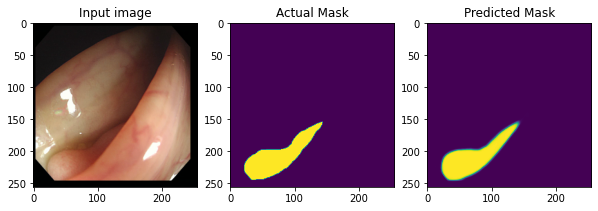

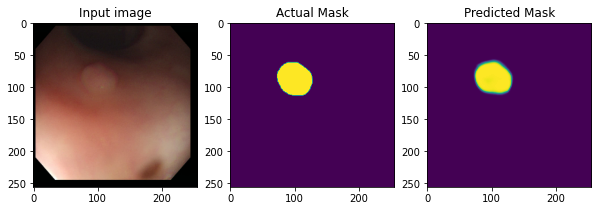

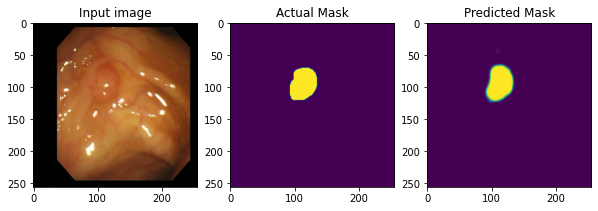

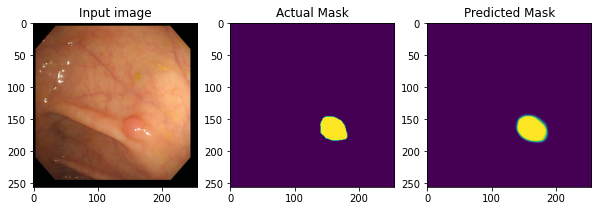

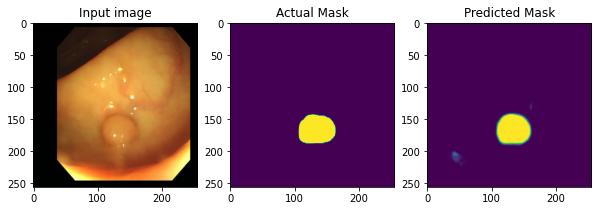

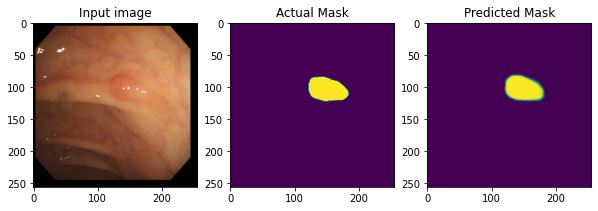

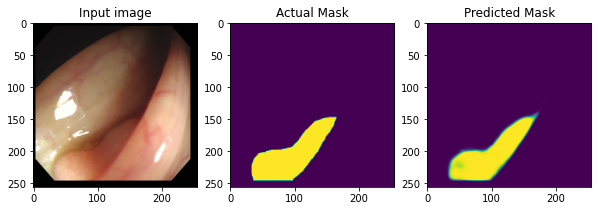

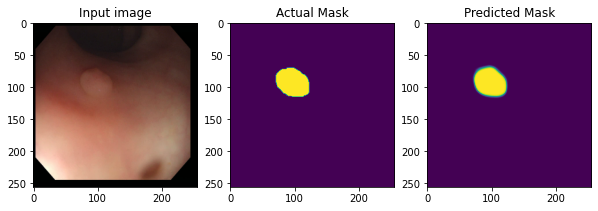

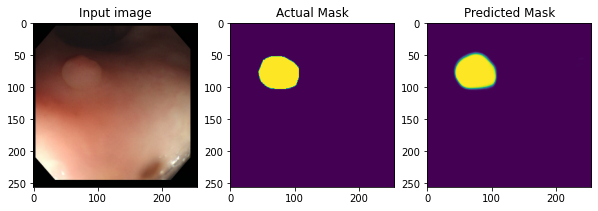

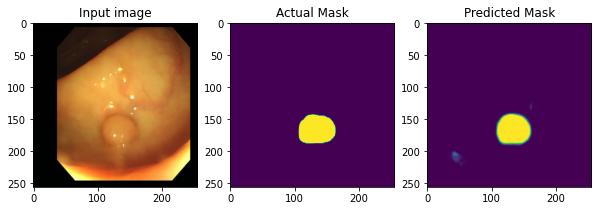

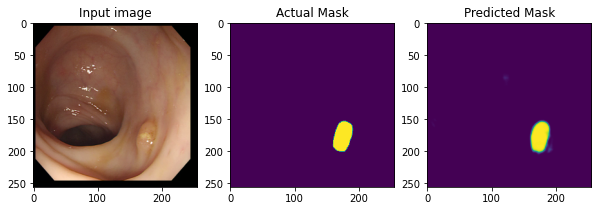

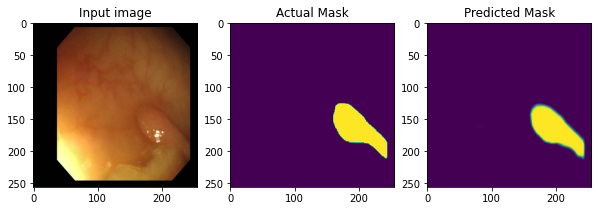

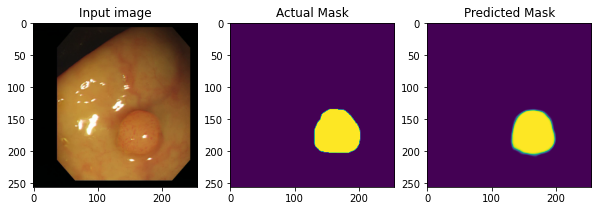

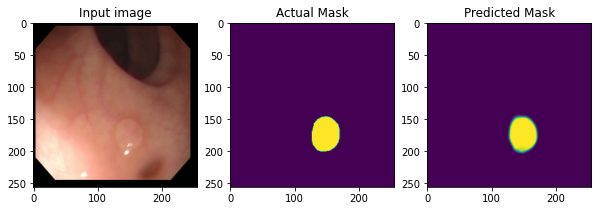

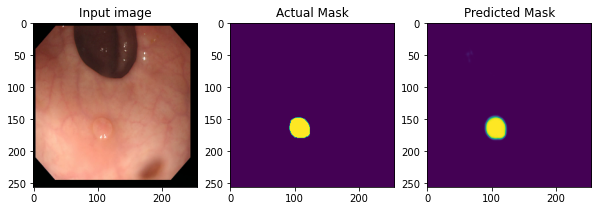

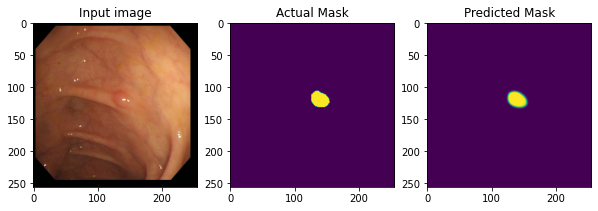

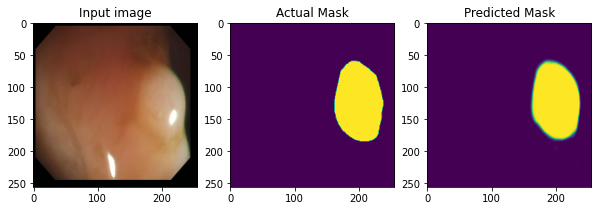

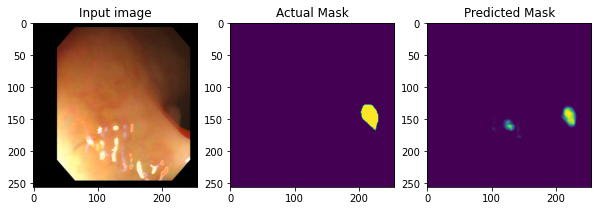

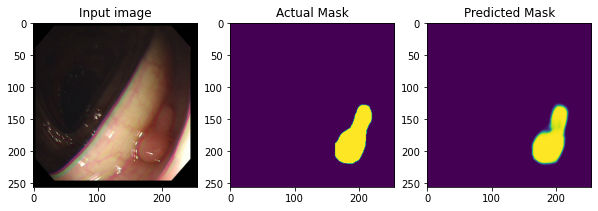

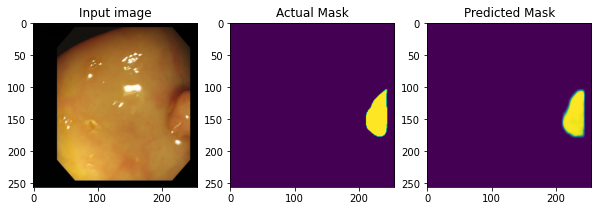

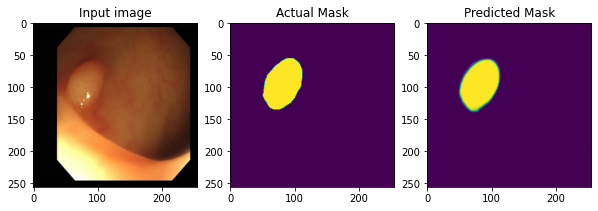

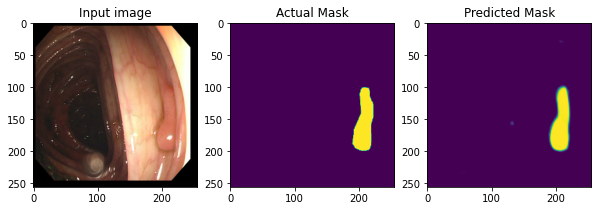

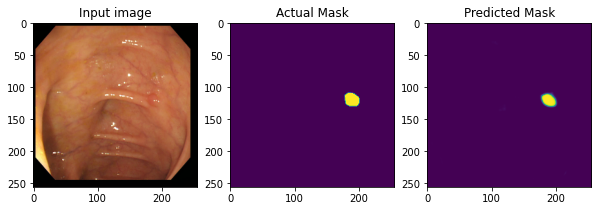

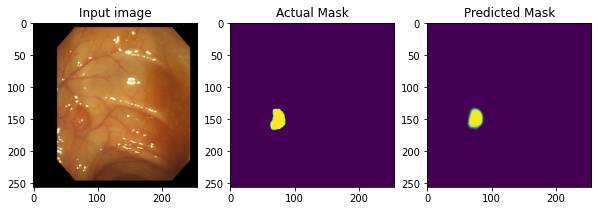

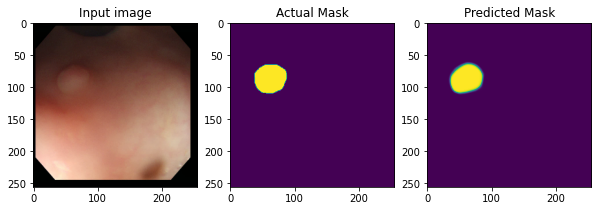

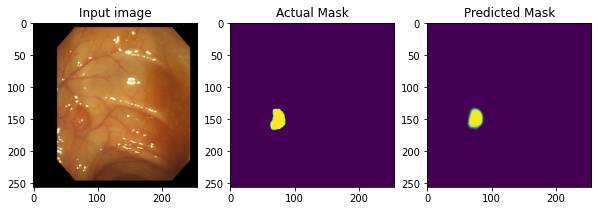

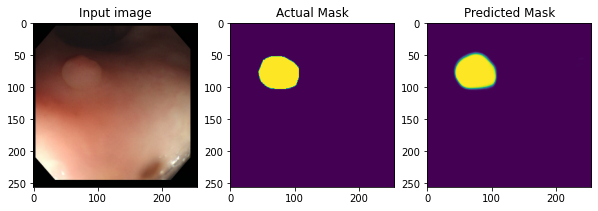

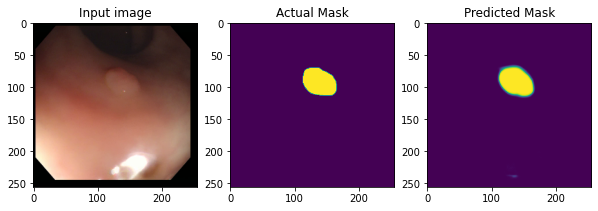

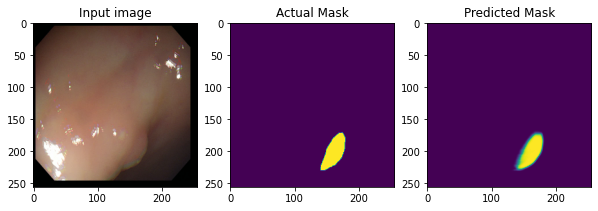

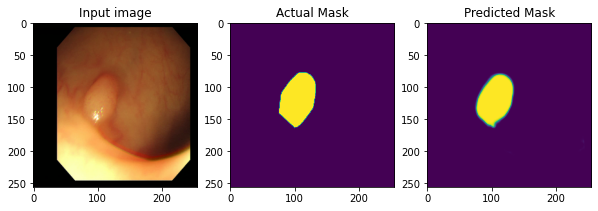

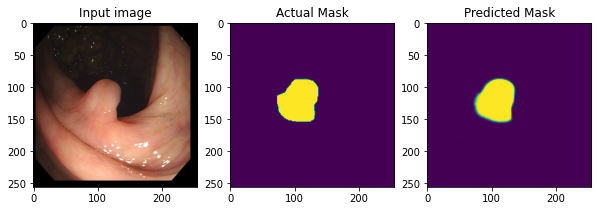

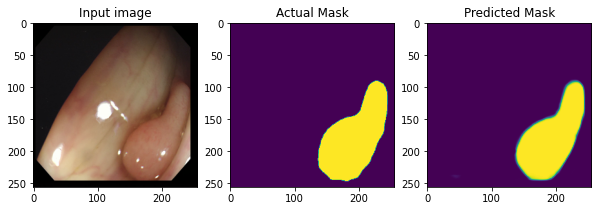

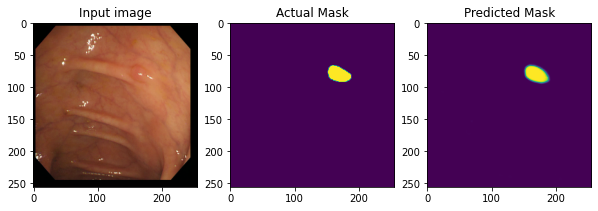

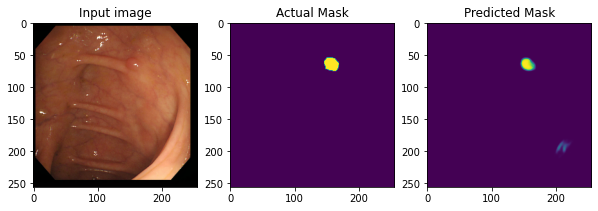

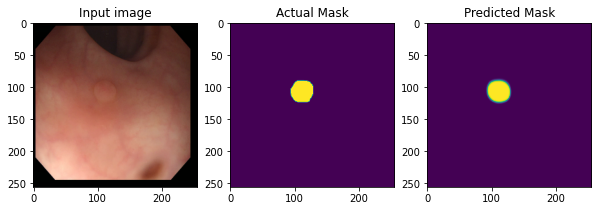

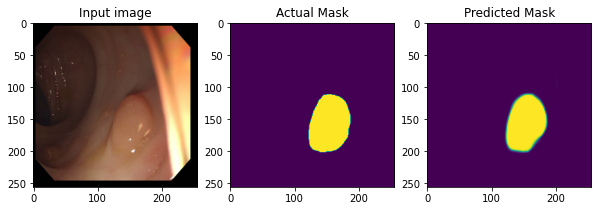

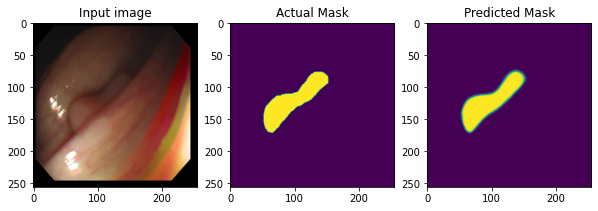

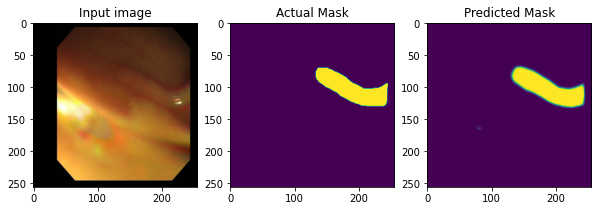

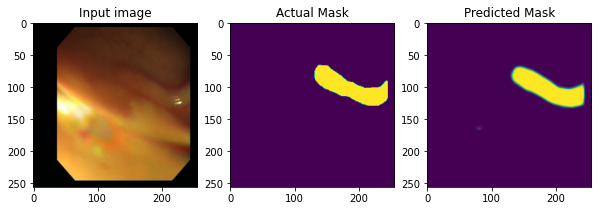

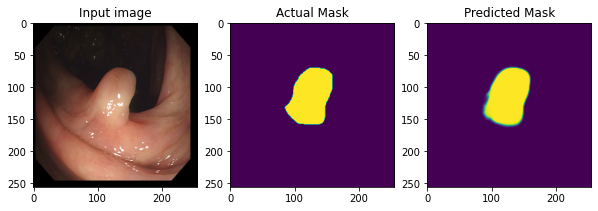

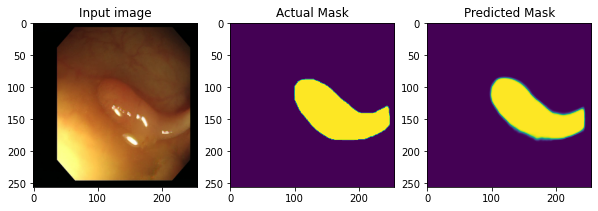

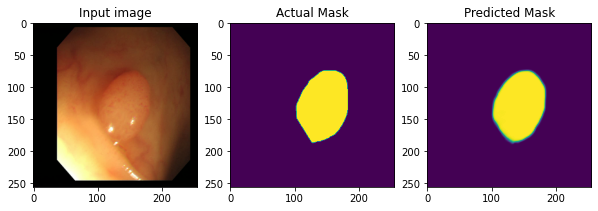

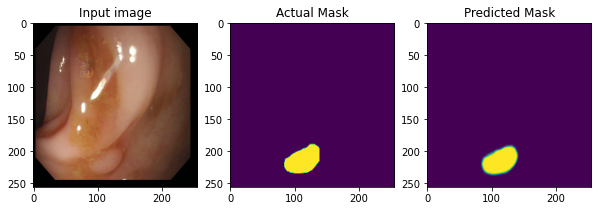

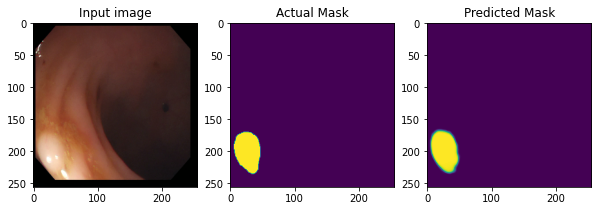

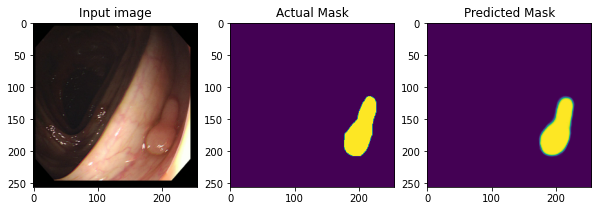

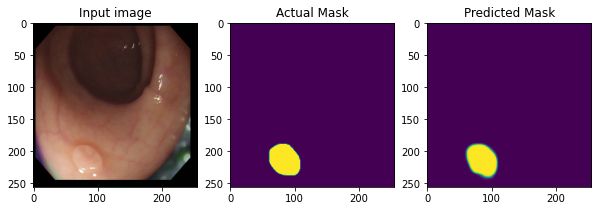

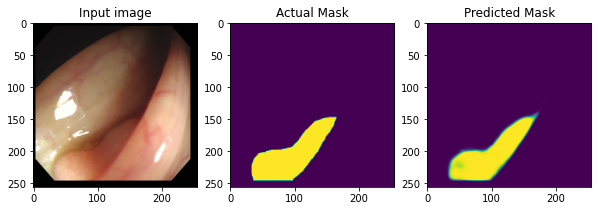

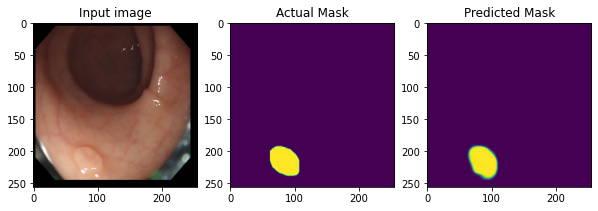

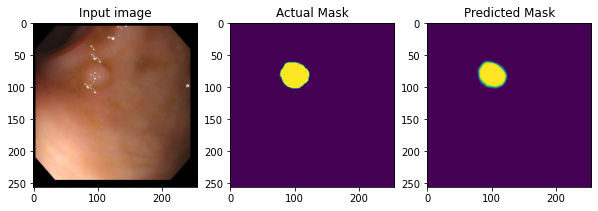

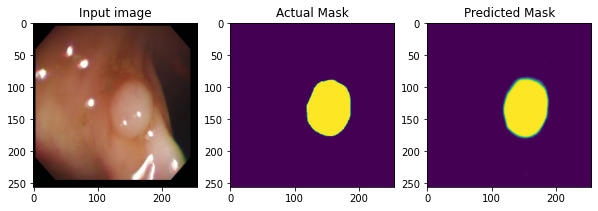

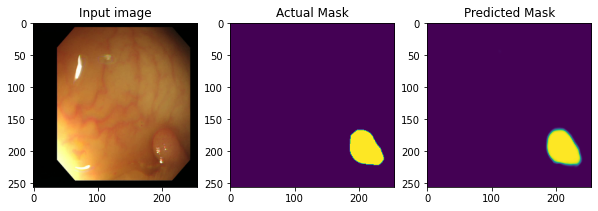

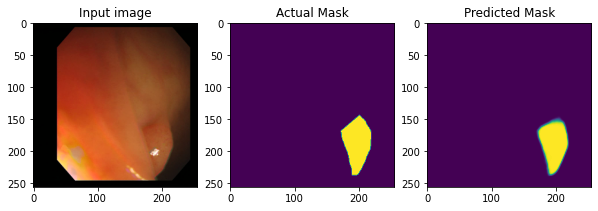

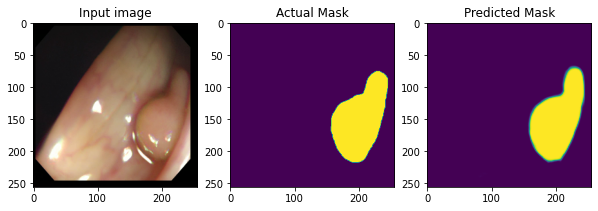

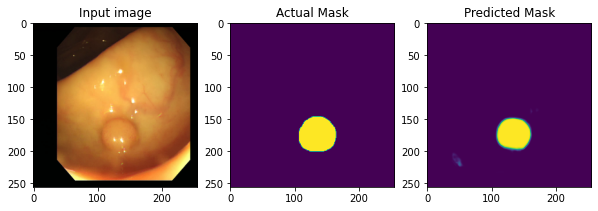

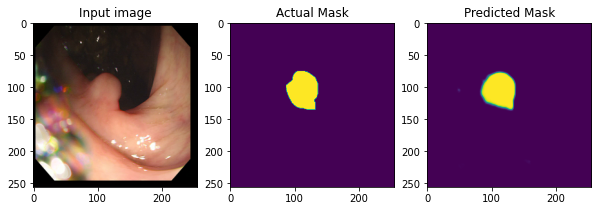

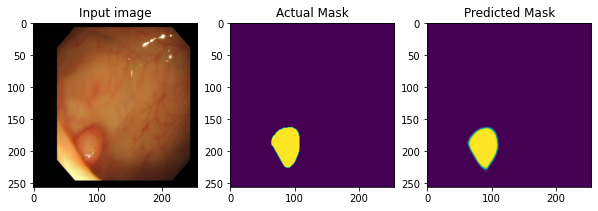

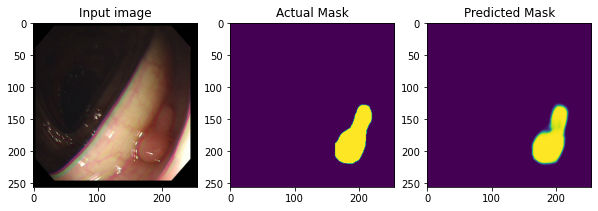

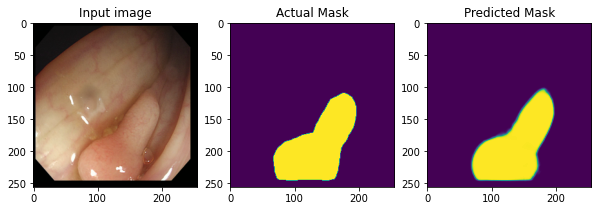

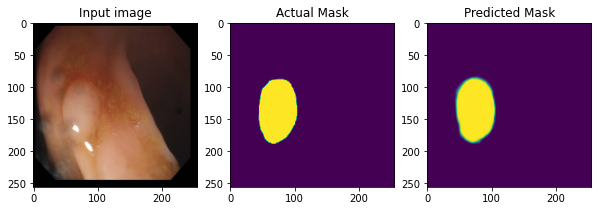

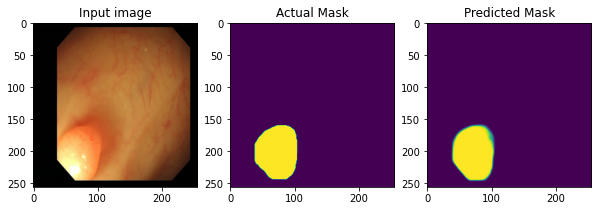

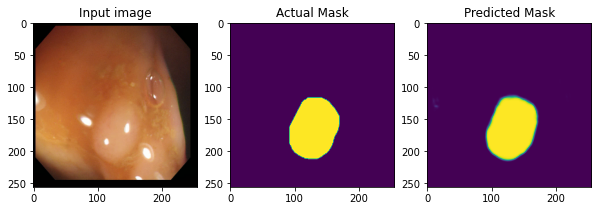

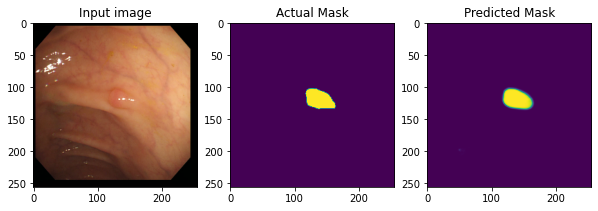

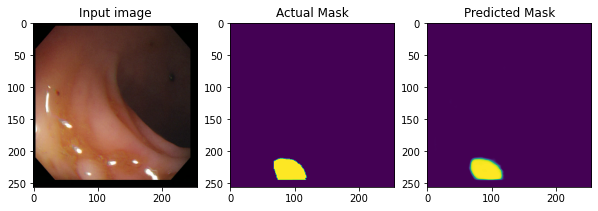

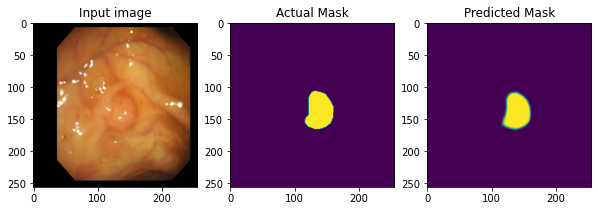

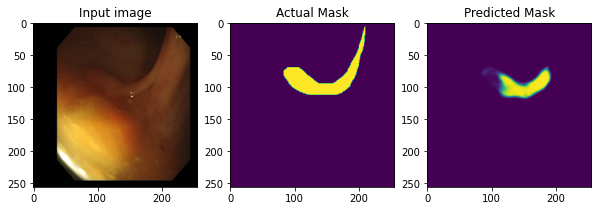

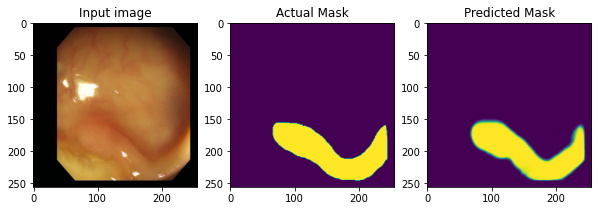

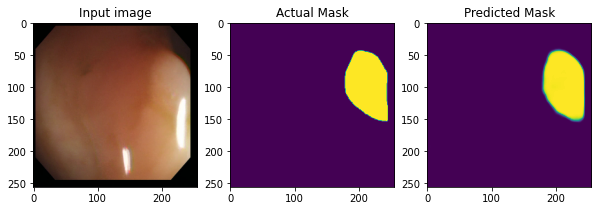

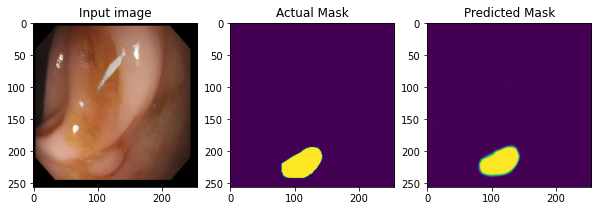

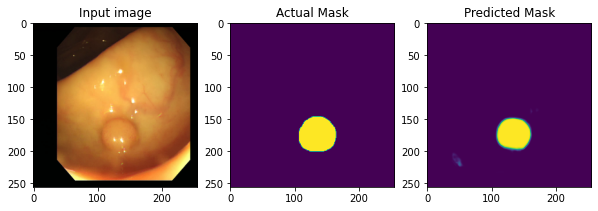

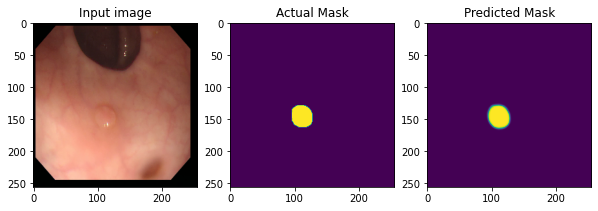

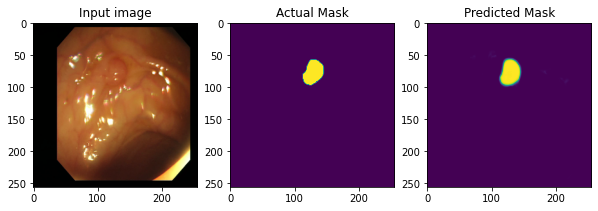

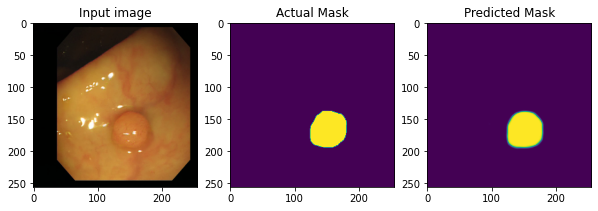

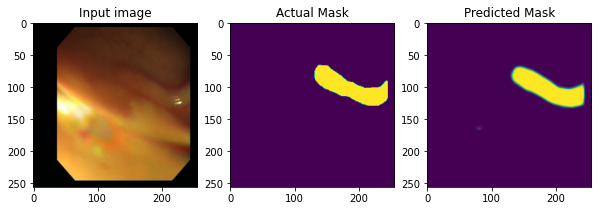

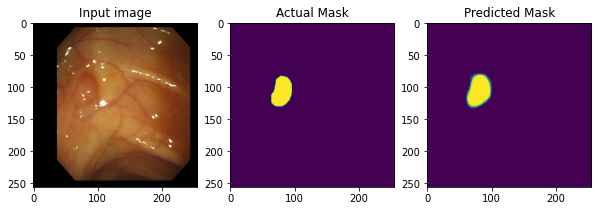

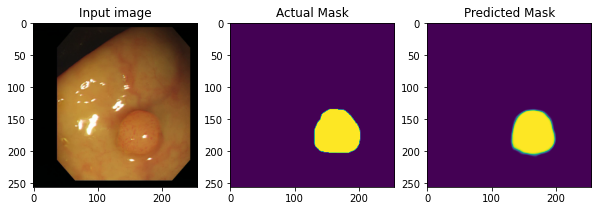

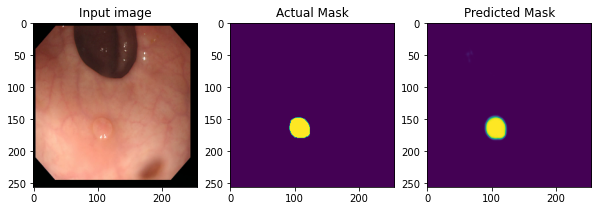

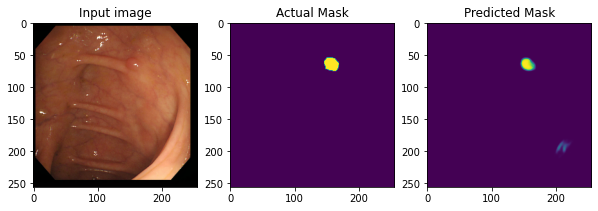

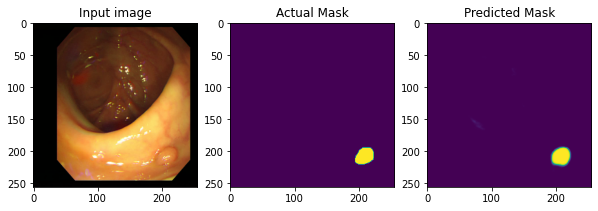

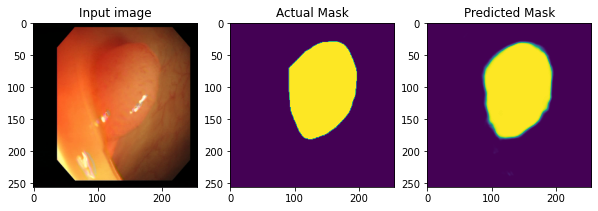

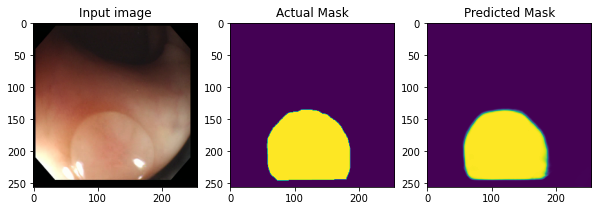

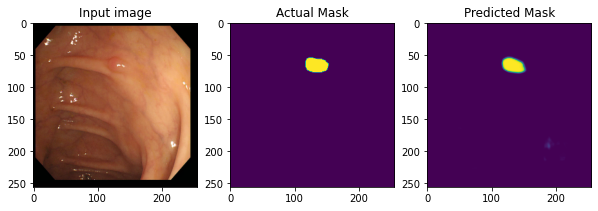

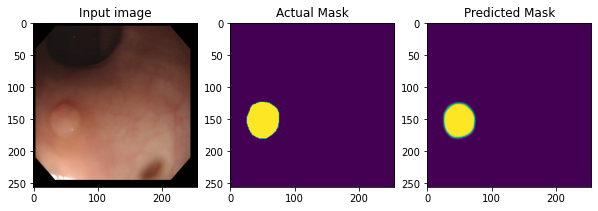

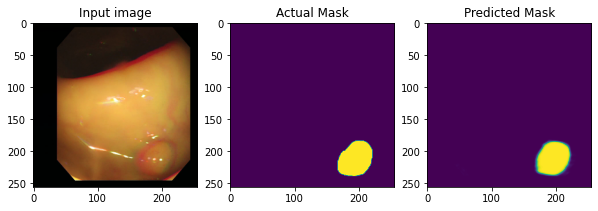

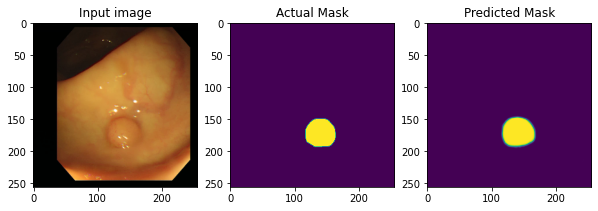

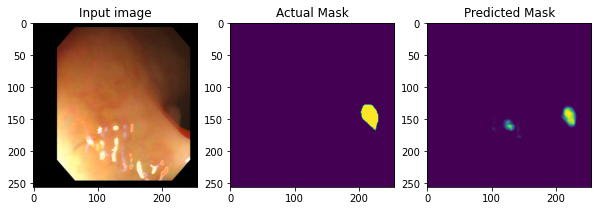

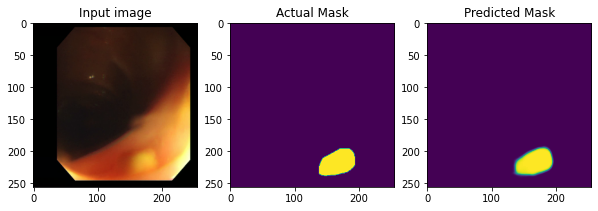

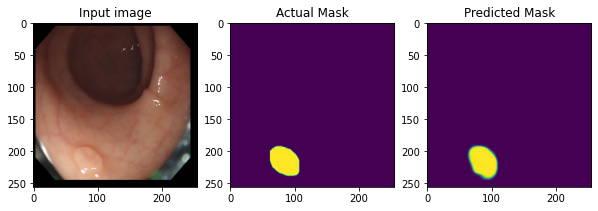

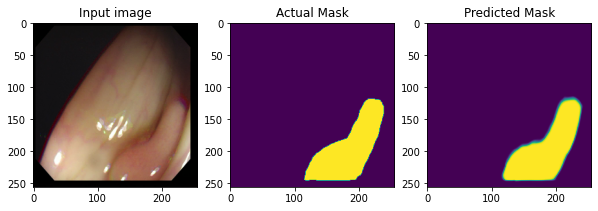

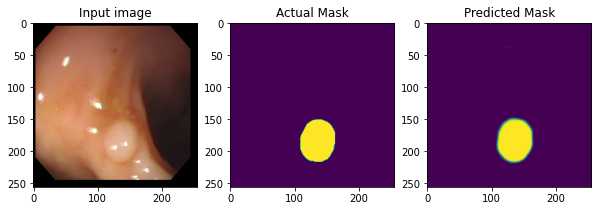

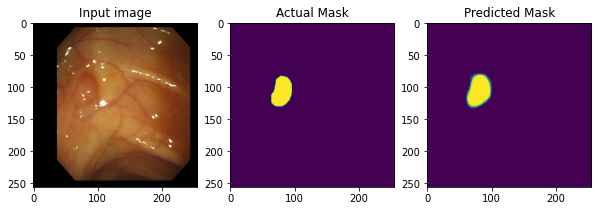

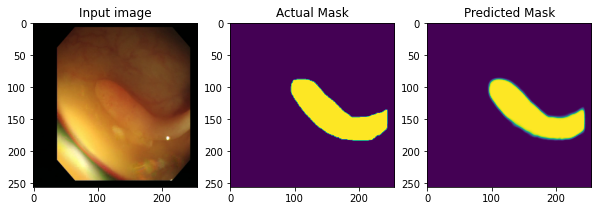

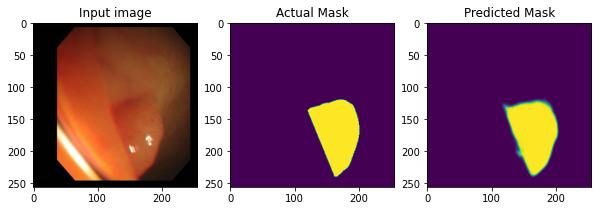

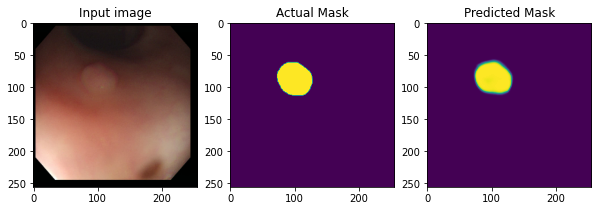

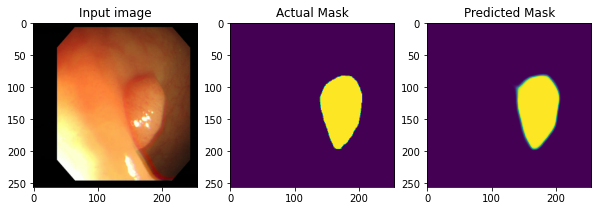

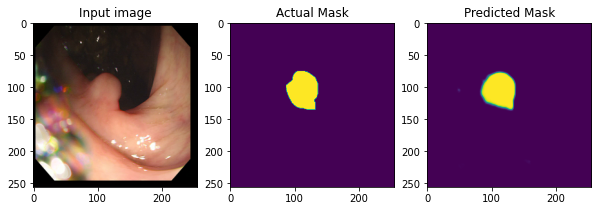

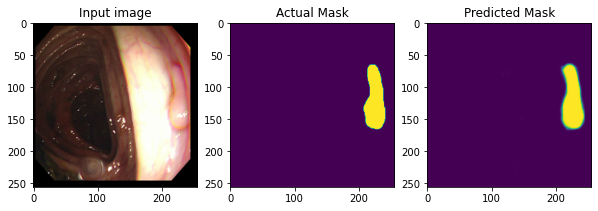

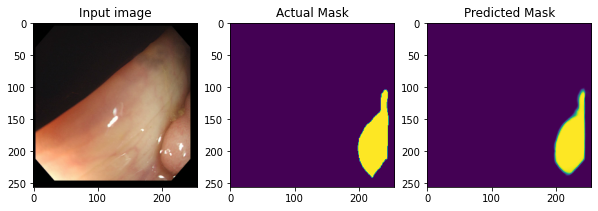

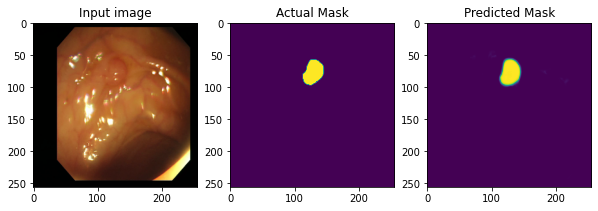

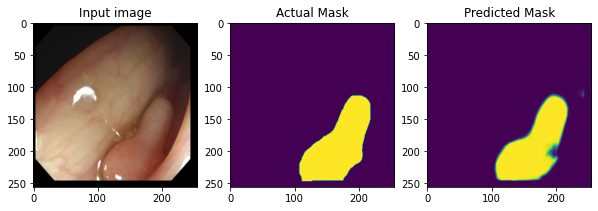

InvalidArgumentError: ignored

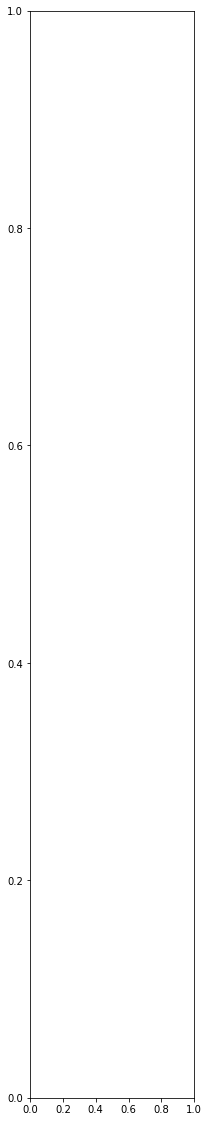

In [147]:
# print sample image after training
for i in range(40):
  print_images(i)

### Plot the loss

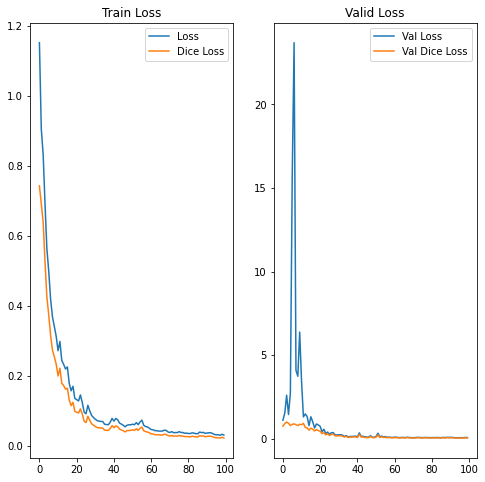

In [94]:
dice_loss = history.history['dice_loss']
loss = history.history['loss']
val_dice_loss = history.history['val_dice_loss']
val_loss = history.history['val_loss']

epochs_range = range(max_epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, loss, label='Loss')
plt.plot(epochs_range, dice_loss, label='Dice Loss')
plt.legend(loc='upper right')
plt.title('Train Loss')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, val_loss, label='Val Loss')
plt.plot(epochs_range, val_dice_loss, label='Val Dice Loss')
plt.legend(loc='upper right')
plt.title('Valid Loss')
plt.show()

In [102]:
model.load_weights(checkpoint_dir)

## Restore the latest checkpoint

In [ ]:
if not is_train:
    # restoring the latest checkpoint in checkpoint_dir
    model.load_weights(checkpoint_dir)

## Evaluate the test dataset

In [95]:
def mean_iou(y_true, y_pred, num_classes=2):
    # Flatten  
    y_true_f = tf.reshape(y_true, [-1])
    y_pred_f = tf.reshape(y_pred, [-1])

    y_true_f = tf.cast(tf.round(y_true_f), dtype=tf.int32).numpy()
    y_pred_f = tf.cast(tf.round(y_pred_f), dtype=tf.int32).numpy()

    # calculate confusion matrix
    labels = list(range(num_classes))
    current = confusion_matrix(y_true_f, y_pred_f, labels=labels)

    # compute mean iou
    intersection = np.diag(current)
    ground_truth_set = current.sum(axis=1)
    predicted_set = current.sum(axis=0)
    union = ground_truth_set + predicted_set - intersection

    IoU = intersection / union.astype(np.float32)
    return np.mean(IoU)

In [96]:
mean = []

for images, labels in test_dataset:
    predictions = model(images, training=False)
    m = mean_iou(labels, predictions)
    mean.append(m)

mean = np.array(mean)
mean = np.mean(mean)
print("mean_iou: {}".format(mean))

mean_iou: 0.9534951203034476
